In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%pip install numpy-financial
import numpy_financial as npf
from scipy. stats import lognorm


Note: you may need to restart the kernel to use updated packages.


**Исходные значения**

In [2]:
mean = 2500 #среднее количество упаковок
st_d = 500  #стандартное отклонение 
n_cookies = 12 #количество печенек в упаковке 
full_price = 50 # цена 1 упаковки
cost = 30 # издержки
discount_price = 15 #уцененные печеньки, проданные в след. день

**Построение логонормального распределения.** <br>
заданные в исходных значениях математическое ожидание и стандартное отклонение необходимо преобразовать для построения логонормального распределения, используя формулы, выражающие математическое ожидание и стандартное отклонение для логонормального распределения через значения нормального распределения. Затем, на основе полученных параметров сгенерировать спрос (dem):

In [3]:
n = 100000
mean_ln = np.log(mean**2/ np.sqrt(mean**2 + st_d**2))
st_d_ln = np.sqrt(np.log((st_d**2/mean**2) + 1))
dem = np.random.lognormal(mean_ln, st_d_ln, n)

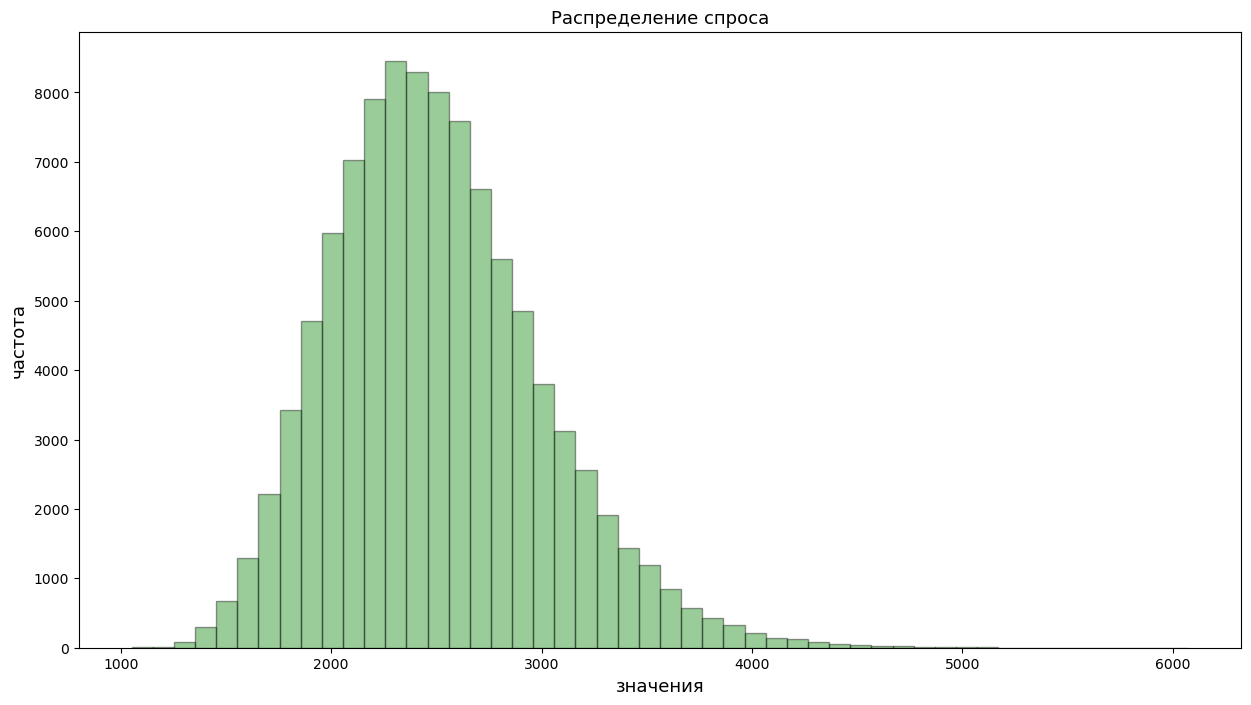

In [4]:
plt.figure(figsize=(15,8))
ax1 = plt.hist(dem, bins=50, ec="k", alpha=0.4, color='g')
plt.title('Распределение спроса', fontsize = 13)
plt.xlabel('значения',fontsize = 13)
plt.ylabel('частота',fontsize = 13)
plt.show()

**Вопрос №1: поиск средней и медианной прибыли**  <br>
1) расчитаем мат.ожидание для спроса на упаковки печенья с помощью формулы для мат. ожидания в логонормальном распределении.
2) производим расчёты для продукции, продаваемой по полной стоимости:
   кол-во продукции ниже или равное мат ожиданию купят в первый день, а значит, всё печенье будет продано по полной стоимости.
3) производим расчёты для продукции, продаваемой по по полной стоимости до мат ожидания и по уценке после мат.ожидания:
   если спрос превышает мат.ожидание, тогда продукцию, равную мат ожиданию купят в первый день, а разницу купят во второй день по сниженной цене.
4) создаём общий массив general_profit, в который попадают все прибыли.

In [5]:
mean_1 = np.exp(mean_ln + st_d_ln ** 2 / 2)

Расчёты для продукции, продаваемой по полной стоимости:

In [6]:
full_price_sales = dem[mean_1 >= dem]
revenue_full = full_price_sales * full_price #выручка от продажи печенья по полной стоимости
costs_full = full_price_sales * cost #издержки от продажи печенья по полной стоимости
profit_full = revenue_full - costs_full #прибыль от продажи печенья по полной стоимости

Расчёты для уцененной продукции:

In [7]:
discount_price_sales = dem[mean_1 < dem]
revenue_discount = (discount_price_sales - mean_1 )*discount_price + mean_1 * full_price #выручка от продажи печенья по уценке+полная стоимость
costs_discount = discount_price_sales * cost #издержки от продажи печенья по уценке+полная стоимость
profit_discount = revenue_discount - costs_discount  #прибыль от продажи печенья по уценке+полная стоимость

In [8]:
general_profit = np.concatenate((profit_full, profit_discount))

**Ответ на вопрос №1:**

In [9]:
print('медианная величина прибыли' , np.median(general_profit),',', 'средняя величина прибыли', np.mean(general_profit))

медианная величина прибыли 44170.10597290621 , средняя величина прибыли 43111.724244265286


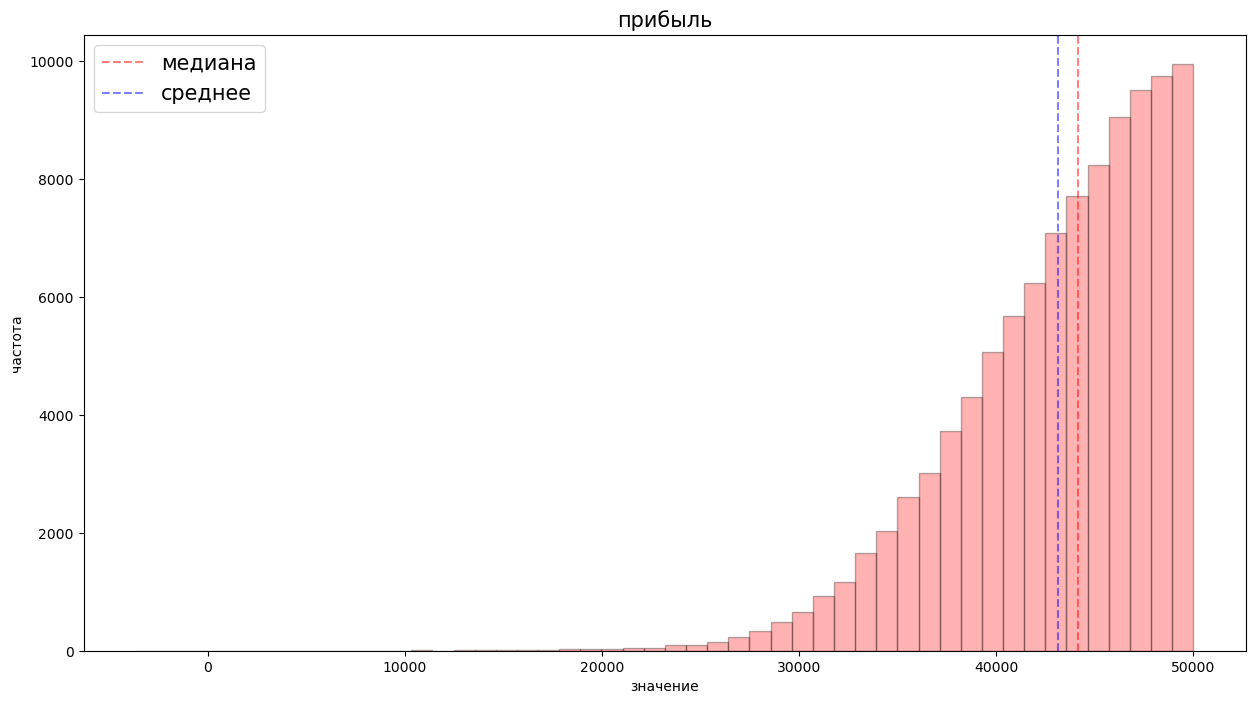

In [10]:
plt.figure(figsize=(15,8))
ax1 = plt.hist(general_profit , bins=50, ec="k", alpha=0.3, color='red')
plt.title('прибыль',fontsize = 15)
plt.axvline(np.median(general_profit), color='red', linestyle='--', alpha=0.5)
plt.axvline(np.mean(general_profit), color='blue', linestyle='--', alpha=0.5)
plt.legend(["медиана" , "среднее"], loc=0, prop={'size': 15})
plt.xlabel('значение',fontsize = 10)
plt.ylabel('частота', fontsize = 10)
plt.show()

**Вопрос №2: поиск оптимального заказа.** <br>
1) задаём массив предложения от минимального значения спроса до максимального значения спроса с шагом 100:
2) создаём функцию "function", которая расчитывает прибыль для двух ситуаций:<br>
   объём спроса выше объема производства (тогда вся продукция будет куплена по полной цене)<br>
   объём спроса ниже объема проиводства (тогда превышение производства над спросом будет продано по сниженной цене)<br>
*функция возвращает средние значения прибылей*<br>
3) создаём функцию function_2, в которой задаём пустой список прибылей. Складываем в него все средние значения прибылей для каждого объема предложения.
4) находим максимум в листе прибылей - **максимальная прибыль является критерием поиска оптимального заказа**
5) находим оптимальный объём производства, который в массиве предложения находится под индексом макс. прибыли
6) находим максимальный объем производства в штуках, умножая оптимальный объём производства на количество печенек :)


In [11]:
supply = np.arange(np.min(dem), np.max(dem),100)   #наше производство от минимального спроса до максимального
def function(mean_ln, st_d_ln, n, production):
    profit = np.zeros(n)
    for i in range(n):
        if dem[i]>= production:
            profit[i] = production * full_price - production * cost
        else:
            profit[i] = ((dem[i] * full_price) + (production - dem[i]) * discount_price) - (production * cost)       
    return(profit.mean())
          
def function_2(mean_ln, st_d_ln, n, supply):
    profit_list = []
    for production in supply:
        profit_list.append(function(mean_ln, st_d_ln, n, production))
    return(profit_list)
    
profit_list = function_2(mean_ln, st_d_ln, n, supply)
max_profit = max(profit_list)
opt_production = supply[profit_list.index(max(profit_list))] 
opt_production_in_pieces = opt_production * n_cookies

**Ответ на вопрос №2:** 

In [12]:
print('максимальный уровень прибыли', max_profit, 'и соответсвующий ему оптимальный объём проивоздства печенья в шт',opt_production_in_pieces )     

максимальный уровень прибыли 43140.36057167036 и соответсвующий ему оптимальный объём проивоздства печенья в шт 30622.966722038866


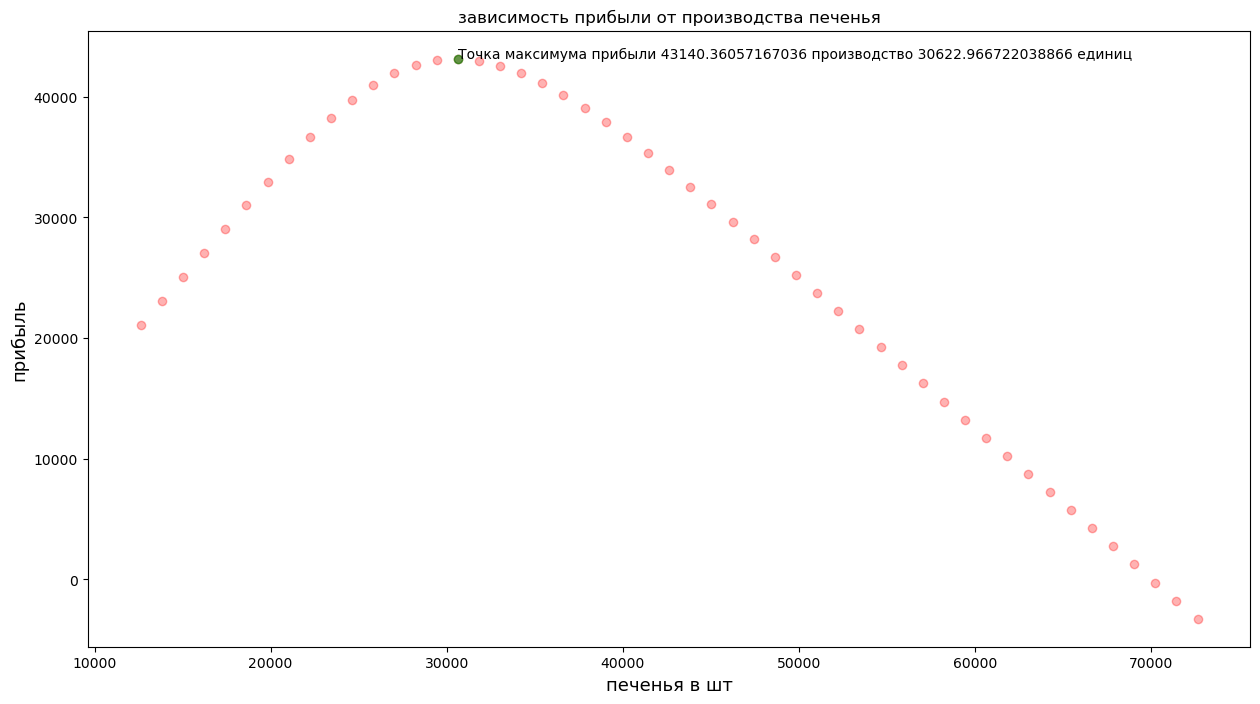

In [13]:
plt.figure(figsize=(15,8))
ax2 = plt.plot( supply*n_cookies, profit_list,'ro', alpha=0.3 )
plt.plot(opt_production_in_pieces , max_profit, 'o', c = 'g', alpha=0.6)
plt.text(opt_production_in_pieces , max_profit, f'Точка максимума прибыли {max_profit} производство {opt_production_in_pieces} единиц ')
plt.title('зависимость прибыли от производства печенья')
plt.xlabel('печенья в шт',fontsize = 13)
plt.ylabel('прибыль', fontsize = 13)
plt.show()

**Вопрос №3: издержки от избытка или недостатка печенья при оптимальном заказе**<br>
1) издержки от недопроизводства: <br>
в случае, когда спрос превышет оптимальный заказ печенек, мы сталкиваемся с ситуацией недопроизводства. и недополученная прибыль = издержки расчитывается следующим образом: <br>
разница между значением спроса и opt_production, умноженная на полную стоимость упаковки печенья за вычетом издержек на производство
2) издержки перепроизводства: <br>
в случае, когда спрос ниже, чем оптимальный заказ печенек, мы сталкиваемся с перепроизводством. Т.е. мы вынуждены продать излишек производства по цене уценки за вычетом издержек. <br>
3) Находим средние значения для двух видов издержек

издержки от недопроизводства

In [14]:
underproduction = dem[dem >=  opt_production]
under_costs = (underproduction - opt_production)*full_price - (underproduction - opt_production)*cost
mean_under_costs = np.mean(under_costs)

издержки перепроизводства

In [15]:
overproduction = dem[ dem < opt_production]
over_costs = (overproduction - opt_production)*discount_price - (overproduction - opt_production)*cost
mean_over_costs = np.mean(over_costs)

**Ответ на вопрос №3:**

In [16]:
print('издержки от недопроизводства в среднем составляют:',mean_under_costs, ',', 'издержки от перепроизводства в среднем составляют:',mean_over_costs)

издержки от недопроизводства в среднем составляют: 8273.912626082125 , издержки от перепроизводства в среднем составляют: 5844.46464527651


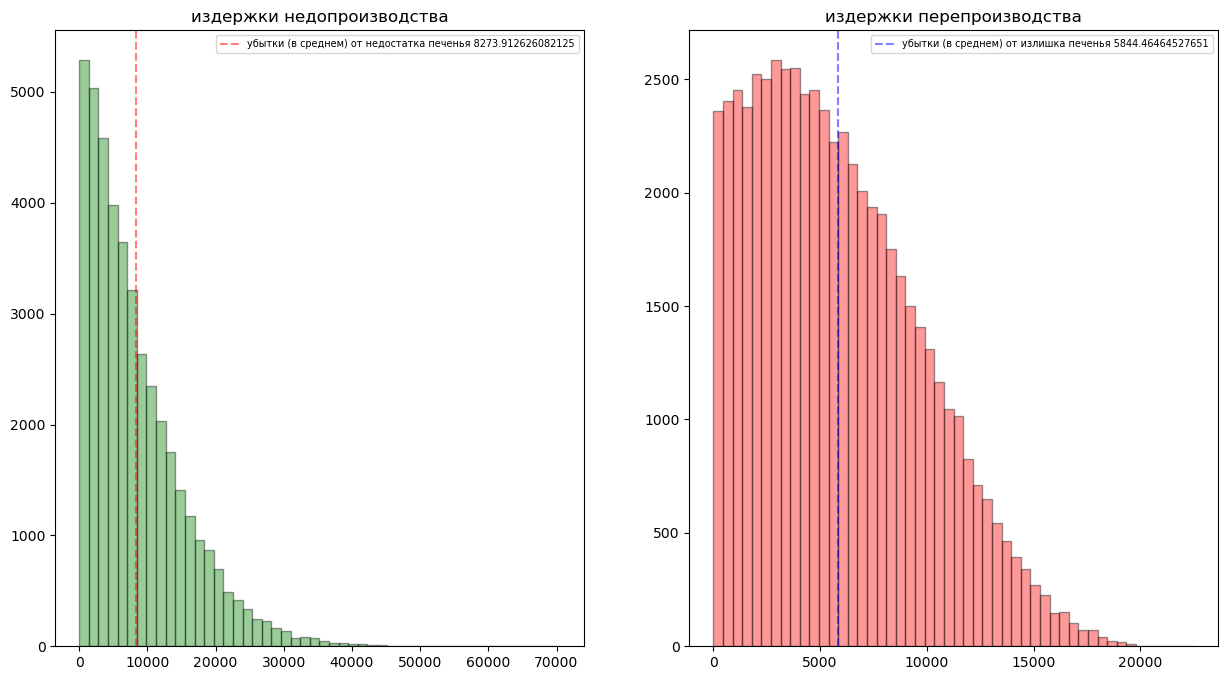

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(under_costs, bins = 50, ec="k", alpha=0.4, color='g')
ax1.set_title('издержки недопроизводства')
ax1.axvline(mean_under_costs, label=f'убытки (в среднем) от недостатка печенья {mean_under_costs}',color='red', linestyle='--', alpha=0.5)
ax1.legend(fontsize = 7)
ax2.hist(over_costs, bins = 50, ec="k", alpha=0.4, color='r')
ax2.set_title('издержки перепроизводства')
ax2.axvline(mean_over_costs, label=f'убытки (в среднем) от излишка печенья {mean_over_costs}', color='blue', linestyle='--', alpha=0.5)
ax2.legend(fontsize = 7)
plt.show()

**ответ на вопрос №4: как изменятся ответы на вопросы 1, 2 и 3, если стандартное отклонение увеличится до 1000 упаковок?**
1) медианная величина прибыли уменьшится с 44170 до 38477
2) средняя величина прибыли уменьшится с 43111 до 36630
3) оптимальный заказ печенья в штуках уменьшится 30622 до 29728
4) издержки от недопроизводства в среднем возрастут с  8273 до 18072 , издержки от перепроизводства в среднем возрастут с 5844 до 9770
  

In [18]:
mean = 2500 #среднее количество упаковок
st_d = 1000  #стандартное отклонение 
n_cookies = 12 #количество печенек в упаковке 
full_price = 50 # цена 1 упаковки
cost = 30 # издержки
discount_price = 15 #уцененные печеньки, проданные в след. день

In [19]:
n = 100000
mean_ln = np.log(mean**2/ np.sqrt(mean**2 + st_d**2))
st_d_ln = np.sqrt(np.log((st_d**2/mean**2) + 1))
dem = np.random.lognormal(mean_ln, st_d_ln, n)

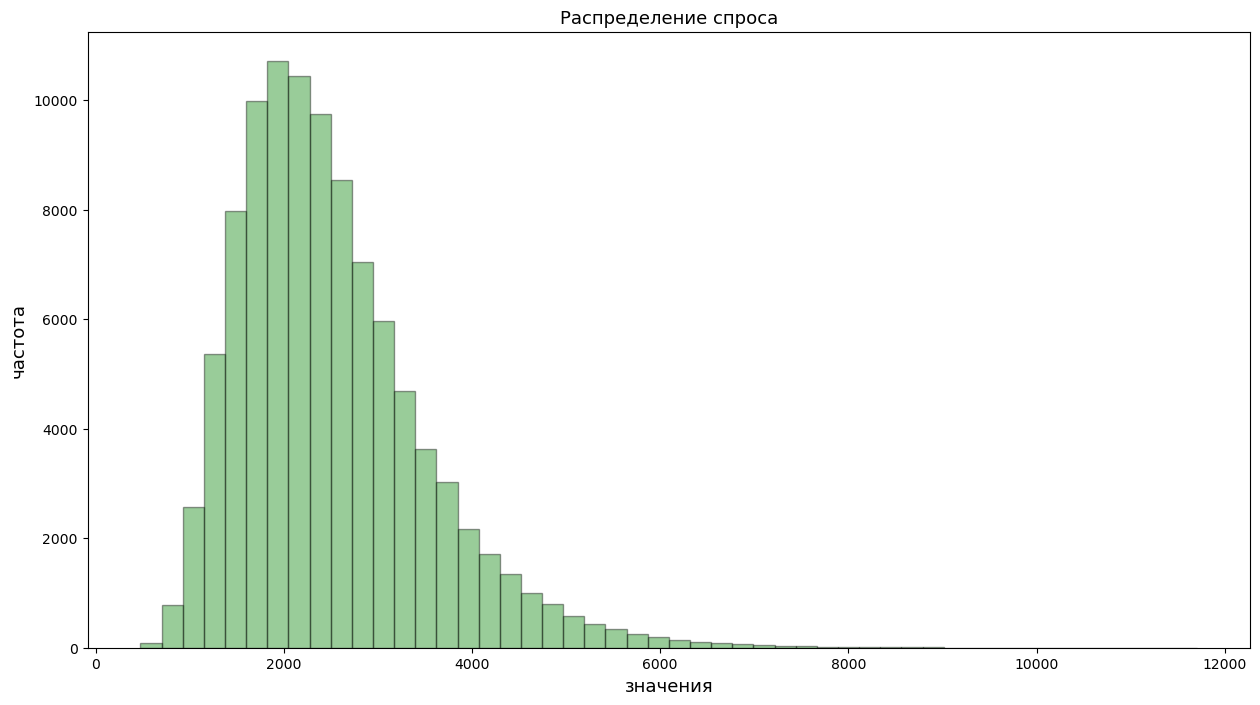

In [20]:
plt.figure(figsize=(15,8))
ax1 = plt.hist(dem, bins=50, ec="k", alpha=0.4, color='g')
plt.title('Распределение спроса', fontsize = 13)
plt.xlabel('значения',fontsize = 13)
plt.ylabel('частота',fontsize = 13)
plt.show()

In [21]:
mean_1 = np.exp(mean_ln + st_d_ln ** 2 / 2)

In [22]:
full_price_sales = dem[mean_1 >= dem]
revenue_full = full_price_sales * full_price #выручка от продажи печенья по полной стоимости
costs_full = full_price_sales * cost #издержки от продажи печенья по полной стоимости
profit_full = revenue_full - costs_full #прибыль от продажи печенья по полной стоимости

In [23]:
discount_price_sales = dem[mean_1 < dem]
revenue_discount = (discount_price_sales - mean_1 )*discount_price + mean_1 * full_price #выручка от продажи печенья по уценке+полная стоимость
costs_discount = discount_price_sales * cost #издержки от продажи печенья по уценке+полная стоимость
profit_discount = revenue_discount - costs_discount  #прибыль от продажи печенья по уценке+полная стоимость

In [24]:
general_profit = np.concatenate((profit_full, profit_discount))

In [25]:
print('медианная величина прибыли' , np.median(general_profit),',', 'средняя величина прибыли', np.mean(general_profit))

медианная величина прибыли 38477.32718257985 , средняя величина прибыли 36630.82999627374


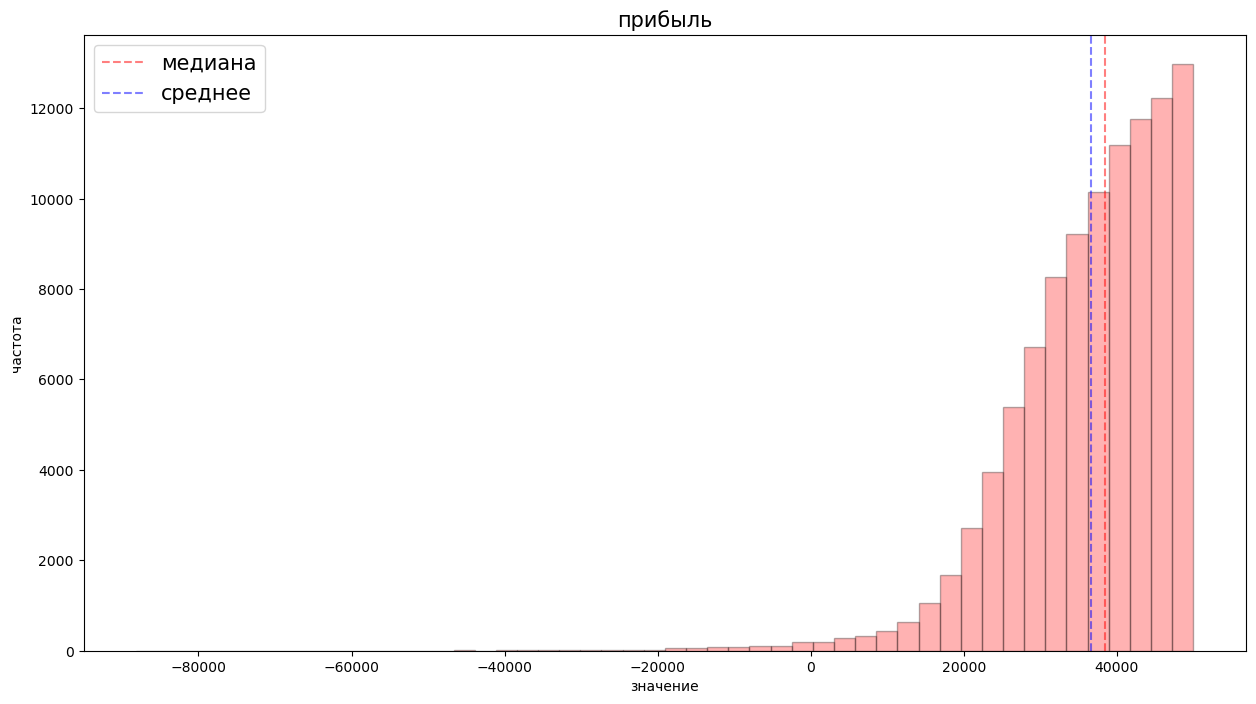

In [26]:
plt.figure(figsize=(15,8))
ax1 = plt.hist(general_profit , bins=50, ec="k", alpha=0.3, color='red')
plt.title('прибыль',fontsize = 15)
plt.axvline(np.median(general_profit), color='red', linestyle='--', alpha=0.5)
plt.axvline(np.mean(general_profit), color='blue', linestyle='--', alpha=0.5)
plt.legend(["медиана" , "среднее"], loc=0, prop={'size': 15})
plt.xlabel('значение',fontsize = 10)
plt.ylabel('частота', fontsize = 10)
plt.show()

In [27]:
supply = np.arange(np.min(dem), np.max(dem),100)   #наше производство от минимального спроса до максимального
def function(mean_ln, st_d_ln, n, production):
    profit = np.zeros(n)
    for i in range(n):
        if dem[i]>= production:
            profit[i] = production * full_price - production * cost
        else:
            profit[i] = ((dem[i] * full_price) + (production - dem[i]) * discount_price) - (production * cost)       
    return(profit.mean())
          
def function_2(mean_ln, st_d_ln, n, supply):
    profit_list = []
    for production in supply:
        profit_list.append(function(mean_ln, st_d_ln, n, production))
    return(profit_list)
    
profit_list = function_2(mean_ln, st_d_ln, n, supply)
max_profit = max(profit_list)
opt_production = supply[profit_list.index(max(profit_list))] 
opt_production_in_pieces = opt_production * n_cookies

In [28]:
print('максимальный уровень прибыли', max_profit, 'и соответсвующий ему оптимальный объём проивоздства печенья в шт',opt_production_in_pieces ) 

максимальный уровень прибыли 36588.438355501654 и соответсвующий ему оптимальный объём проивоздства печенья в шт 29728.636780369176


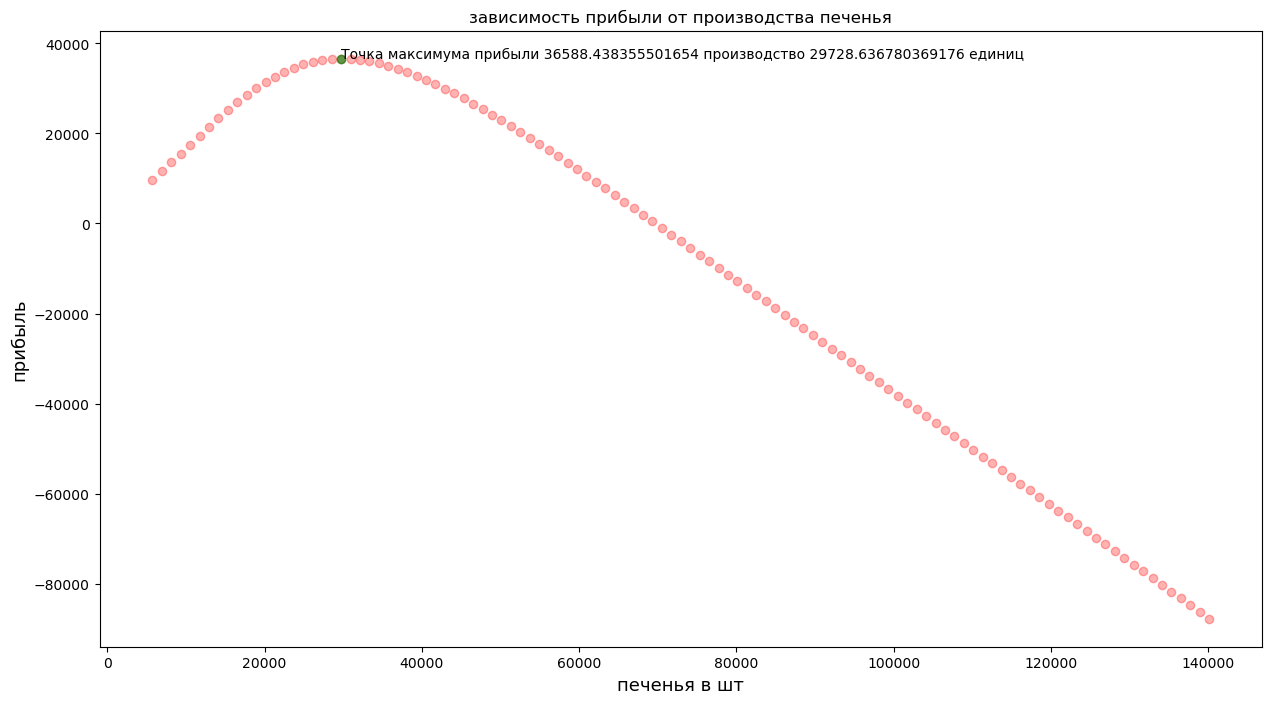

In [29]:
plt.figure(figsize=(15,8))
ax2 = plt.plot( supply*n_cookies, profit_list,'ro', alpha=0.3 )
plt.plot(opt_production_in_pieces , max_profit, 'o', c = 'g', alpha=0.6)
plt.text(opt_production_in_pieces , max_profit, f'Точка максимума прибыли {max_profit} производство {opt_production_in_pieces} единиц ')
plt.title('зависимость прибыли от производства печенья')
plt.xlabel('печенья в шт',fontsize = 13)
plt.ylabel('прибыль', fontsize = 13)
plt.show()

In [30]:
underproduction = dem[dem >=  opt_production]
under_costs = (underproduction - opt_production)*full_price - (underproduction - opt_production)*cost
mean_under_costs = np.mean(under_costs)

In [31]:
overproduction = dem[ dem < opt_production]
over_costs = (overproduction - opt_production)*discount_price - (overproduction - opt_production)*cost
mean_over_costs = np.mean(over_costs)

In [32]:
print('издержки от недопроизводства в среднем составляют:',mean_under_costs, ',', 'издержки от перепроизводства в среднем составляют:',mean_over_costs)

издержки от недопроизводства в среднем составляют: 18072.653368344127 , издержки от перепроизводства в среднем составляют: 9770.567275687072


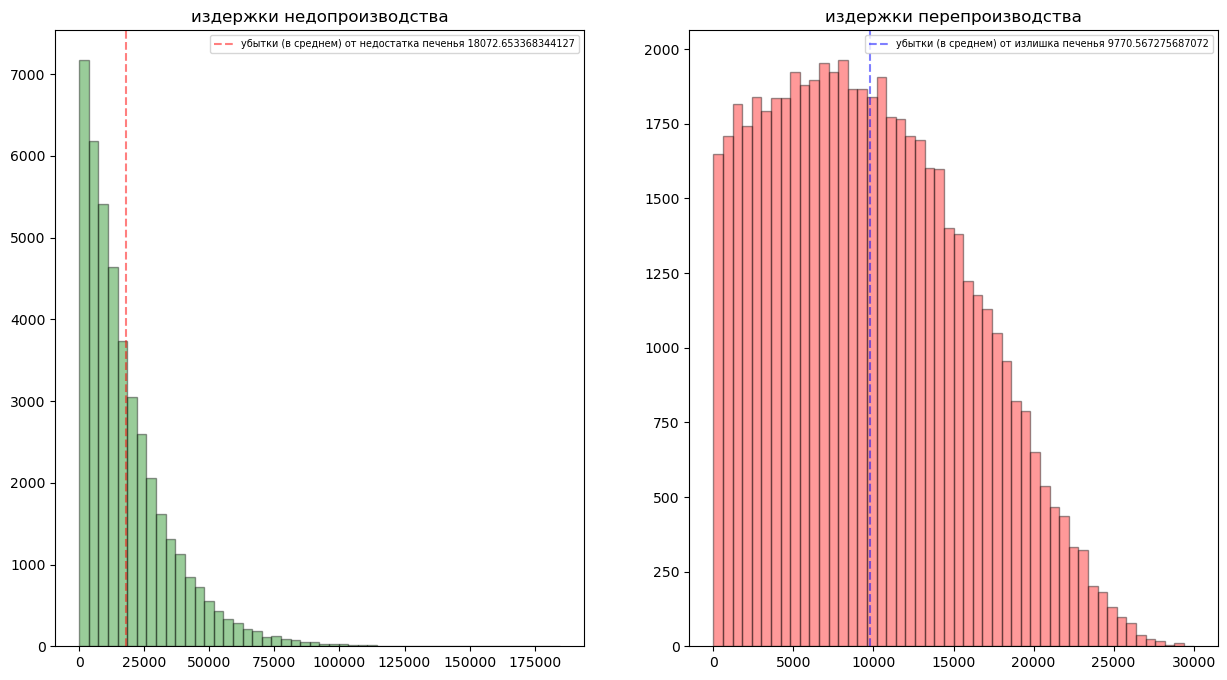

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(under_costs, bins = 50, ec="k", alpha=0.4, color='g')
ax1.set_title('издержки недопроизводства')
ax1.axvline(mean_under_costs, label=f'убытки (в среднем) от недостатка печенья {mean_under_costs}',color='red', linestyle='--', alpha=0.5)
ax1.legend(fontsize = 7)
ax2.hist(over_costs, bins = 50, ec="k", alpha=0.4, color='r')
ax2.set_title('издержки перепроизводства')
ax2.axvline(mean_over_costs, label=f'убытки (в среднем) от излишка печенья {mean_over_costs}', color='blue', linestyle='--', alpha=0.5)
ax2.legend(fontsize = 7)
plt.show()